In [5]:
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# Guiding (Jastrow) wavefunction
# ============================================================

def log_psi_guiding_from_Nf(Nf, gamma: float, Nplaquettes: int):
    """
    Logarithm of a simple Jastrow-like guiding wavefunction:

        psi_G(C; gamma) = exp[ gamma * Nf(C) / Nplaquettes ]

    where Nf(C) is the number of flippable plaquettes in configuration C,
    and Nplaquettes = L^2.

    gamma > 0 favours configurations with many flippable plaquettes.
    gamma < 0 favours configurations with few flippable plaquettes.

    This function is used inside GFMC for importance sampling; in VMC we
    use the same form to define |psi_G|^2 as the sampling distribution.
    """
    return gamma * (Nf / float(Nplaquettes))


# ============================================================
# Dimer lattice helpers (H/V representation)
# ============================================================

def initialize_columnar_configs(L: int, Nw: int):
    """
    Initialize Nw walkers on an LxL periodic lattice with simple
    columnar dimer coverings (half vertical, half horizontal).

    Geometry / convention:
      - Sites are labeled (x, y) with:
            x = 0..L-1  (left to right)
            y = 0..L-1  (bottom to top)
        so (0,0) is the *bottom-left* site.

      - h[iw, x, y] = 1 if walker iw has a HORIZONTAL dimer on bond
                      (x, y) -> (x+1, y)     (modulo L)
      - v[iw, x, y] = 1 if walker iw has a VERTICAL dimer on bond
                      (x, y) -> (x, y+1)     (modulo L)

    For L even, the following patterns are close-packed dimers:
      - Vertical columnar: v[:, :, even y] = 1
      - Horizontal columnar: h[:, even x, :] = 1
    """
    if L % 2 != 0:
        raise ValueError("L must be even for close-packed dimers with PBC.")

    h = np.zeros((Nw, L, L), dtype=np.uint8)
    v = np.zeros((Nw, L, L), dtype=np.uint8)

    for iw in range(Nw):
        if iw % 2 == 0:
            # Vertical columnar pattern
            v[iw, :, 0::2] = 1
        else:
            # Horizontal columnar pattern
            h[iw, 0::2, :] = 1

    return h, v


def plaquette_state_single(h_single: np.ndarray, v_single: np.ndarray, x: int, y: int) -> int:
    """
    Plaquette with bottom-left corner at (x, y) on a periodic LxL lattice.

    Returns:
        +1  if plaquette is horizontally flippable  (two horizontal dimers)
        -1  if plaquette is vertically flippable    (two vertical dimers)
         0  otherwise (not flippable)

    Edges of plaquette p at (x,y):
      bottom: h[x, y]
      top:    h[x, y+1]
      left:   v[x, y]
      right:  v[x+1, y]
    """
    L = h_single.shape[0]
    xp = (x + 1) % L
    yp = (y + 1) % L

    h_bottom = h_single[x, y]
    h_top    = h_single[x, yp]
    v_left   = v_single[x, y]
    v_right  = v_single[xp, y]

    # horizontally flippable
    if h_bottom and h_top and not v_left and not v_right:
        return 1

    # vertically flippable
    if v_left and v_right and not h_bottom and not h_top:
        return -1

    return 0


def compute_flippable_map(h_single: np.ndarray, v_single: np.ndarray) -> np.ndarray:
    """
    Compute boolean map of flippable plaquettes for a single configuration.

    flippable[x, y] is True if plaquette (x, y) is either
    horizontally or vertically flippable.
    """
    L = h_single.shape[0]
    flippable = np.zeros((L, L), dtype=bool)
    for x in range(L):
        for y in range(L):
            flippable[x, y] = (plaquette_state_single(h_single, v_single, x, y) != 0)
    return flippable


def affected_plaquettes(x: int, y: int, L: int):
    """
    Plaquette (x,y) only affects the flippability of itself and its four
    nearest plaquette neighbors. Return the list of (qx,qy) indices to check.
    """
    return [
        (x, y),
        ((x + 1) % L, y),
        ((x - 1) % L, y),
        (x, (y + 1) % L),
        (x, (y - 1) % L),
    ]


def flip_plaquette_and_update(
    h_single: np.ndarray,
    v_single: np.ndarray,
    flippable_single: np.ndarray,
    x: int,
    y: int,
) -> int:
    """
    Perform a Rokhsar-Kivelson plaquette flip at plaquette (x, y)
    for a single configuration, if flippable. Update flippable_single
    locally in a 5-plaquette neighborhood.

    Returns:
        dNf : change in the total number of flippable plaquettes Nf
              If the plaquette is not flippable in its current orientation,
              returns 0 and leaves the configuration unchanged.

    IMPORTANT:
      - This function MUTATES h_single, v_single, flippable_single.
      - Applying it twice at the same (x,y) returns to the original config,
        and the two dNf's sum to zero.
    """
    L = h_single.shape[0]
    xp = (x + 1) % L
    yp = (y + 1) % L

    h_bottom = h_single[x, y]
    h_top    = h_single[x, yp]
    v_left   = v_single[x, y]
    v_right  = v_single[xp, y]

    flipped = False

    # Decide which way (if any) to flip: horizontal <-> vertical
    if h_bottom and h_top and not v_left and not v_right:
        # horizontal -> vertical
        h_single[x, y]  = 0
        h_single[x, yp] = 0
        v_single[x, y]  = 1
        v_single[xp, y] = 1
        flipped = True
    elif v_left and v_right and not h_bottom and not h_top:
        # vertical -> horizontal
        v_single[x, y]  = 0
        v_single[xp, y] = 0
        h_single[x, y]  = 1
        h_single[x, yp] = 1
        flipped = True

    if not flipped:
        return 0

    # Update flippability locally in 5-plaquette neighborhood
    dNf = 0
    for qx, qy in affected_plaquettes(x, y, L):
        old_flippable = flippable_single[qx, qy]
        new_flippable = (plaquette_state_single(h_single, v_single, qx, qy) != 0)
        flippable_single[qx, qy] = new_flippable

        if old_flippable and not new_flippable:
            dNf -= 1
        elif (not old_flippable) and new_flippable:
            dNf += 1

    return dNf


def measure_profile_line(h_single: np.ndarray, v_single: np.ndarray) -> np.ndarray:
    """
    Plaquette orientation profile along a VERTICAL line:

      Fix x = L//2 (middle column of plaquettes). For each y:

        G[y] = +1 if plaquette is horizontally flippable
               -1 if vertically flippable
                0 otherwise

    This is a 1D "slice" order parameter used to diagnose columnar/plaquette/mixed.
    """
    L = h_single.shape[0]
    G = np.zeros(L, dtype=float)

    x_fixed = L // 2
    for y in range(L):
        state = plaquette_state_single(h_single, v_single, x_fixed, y)
        if state == 1:
            G[y] = 1.0
        elif state == -1:
            G[y] = -1.0
        else:
            G[y] = 0.0

    return G


def measure_avg_plaquette_orientation(h_single: np.ndarray, v_single: np.ndarray) -> float:
    """
    Average plaquette orientation over the entire lattice:

      B_p = +1 if horizontally flippable
            -1 if vertically flippable
             0 otherwise

      <B> = (1/L^2) sum_p B_p

    This is another global order parameter.
    """
    L = h_single.shape[0]
    total = 0.0
    for x in range(L):
        for y in range(L):
            total += plaquette_state_single(h_single, v_single, x, y)
    return total / (L * L)


# Wavevectors at which we evaluate structure factors
Q_PEAKS = [
    (np.pi, 0.0),    # (pi, 0)
    (0.0, np.pi),    # (0, pi)
    (np.pi, np.pi),  # (pi, pi)
]


def measure_structure_factor_peaks(
    h_single: np.ndarray,
    v_single: np.ndarray,
    q_list=Q_PEAKS,
):
    """
    Evaluate dimer structure factor peaks for horizontal and vertical dimers
    at a set of momenta q_list.

    For each q = (qx,qy), compute:

       Sx(q) = (1/N) | sum_r n_x(r) e^{i q·r} |^2
       Sy(q) = (1/N) | sum_r n_y(r) e^{i q·r} |^2

    where n_x(r) = h[x,y], n_y(r) = v[x,y].

    Here we treat bond centers as living at integer coordinates (x,y);
    this is fine for commensurate q like (pi,0), (0,pi), (pi,pi).

    Returns:
        Sx_vals, Sy_vals : 1D arrays of shape (len(q_list),)
    """
    L = h_single.shape[0]
    x_coords, y_coords = np.meshgrid(np.arange(L), np.arange(L), indexing="ij")

    n_norm = float(L * L)
    Sx_vals = np.empty(len(q_list), dtype=float)
    Sy_vals = np.empty(len(q_list), dtype=float)

    n_x = h_single.astype(float)
    n_y = v_single.astype(float)

    for idx, (qx, qy) in enumerate(q_list):
        phase = np.exp(1j * (qx * x_coords + qy * y_coords))
        Sx = np.abs((n_x * phase).sum())**2 / n_norm
        Sy = np.abs((n_y * phase).sum())**2 / n_norm
        Sx_vals[idx] = Sx.real
        Sy_vals[idx] = Sy.real

    return Sx_vals, Sy_vals


# ============================================================
# GFMC core (with guiding)
# ============================================================

def lgfmc(
    k: int = 8,
    Nw: int = 30,
    P: float = 0.5,
    gamma: float = 0.0,
    Mct: int = 20_000,
    Mck: int = 100,
    Mcx: int = 10_000,
    Mcf: int = 1_000,
):
    """
    Green's Function Monte Carlo for the square-lattice quantum dimer model
    using an H/V dimer representation and a simple Jastrow guiding function.

    Parameters:
        k     : controls lattice size L = 2*k
        Nw    : number of walkers
        P     : (J - V)/J parameter in the QDM (used in diagonal Green's function)
        gamma : guiding parameter in psi_G(C) = exp[ gamma * Nf(C) / L^2 ]
        Mct   : number of reconfigurations used for measurement
        Mck   : number of time steps between reconfigurations
        Mcx   : number of thermalization reconfigurations
        Mcf   : interval for progress prints

    Returns:
        dict with fields needed for forward walking and analysis:
            h, v : final configurations (Nw, L, L)
            nf   : Nf history (McT, Nw)
            O    : measured operator history (McT, Nw, op_dim)
            jw   : ancestry indices (McT, Nw)
            wt   : log normalization factors per reconfig (McT,)
            lw   : log weights per walker (McT, Nw)
            L    : lattice size
            Nw   : number of walkers
            Mct, Mcx, McT
    """
    # Lattice size and basic counts
    L = 2 * k               # even linear size
    Nplaquettes = L * L
    McT = Mct + Mcx

    # Initialize walkers
    h, v = initialize_columnar_configs(L, Nw)

    # Flippability maps and Nf for each walker
    flippable = np.zeros((Nw, L, L), dtype=bool)
    Nf = np.zeros(Nw, dtype=int)
    for iw in range(Nw):
        flippable[iw] = compute_flippable_map(h[iw], v[iw])
        Nf[iw] = np.count_nonzero(flippable[iw])

    # GFMC bookkeeping
    lw = np.zeros((McT, Nw), dtype=float)  # log weights per walker per reconfig
    wt = np.zeros(McT, dtype=float)        # log normalization per reconfig
    nf = np.zeros((McT, Nw), dtype=int)    # Nf history
    nf[0, :] = Nf

    # Observable layout:
    #   0 .. L-1                 : G(y) profile along vertical cut
    #   L                        : average plaquette orientation <B>
    #   L+1 .. L+3               : Sx(q) at q = (pi,0),(0,pi),(pi,pi)
    #   L+4 .. L+6               : Sy(q) at same qs
    n_q = len(Q_PEAKS)
    op_dim = L + 1 + 2 * n_q
    O = np.zeros((McT, Nw, op_dim), dtype=float)

    jw = np.zeros((McT, Nw), dtype=int)           # ancestry indices

    # Random seed (like rng('shuffle') in MATLAB)
    np.random.seed()

    print("Starting GFMC run...", flush=True)
    print(f"GFMC guiding parameter gamma = {gamma}", flush=True)

    # Main GFMC loop over reconfigurations
    for it in range(1, McT):
        # Work with copies for this reconfiguration
        h_curr = h.copy()
        v_curr = v.copy()
        flipp_curr = flippable.copy()
        Nf_curr = nf[it - 1].copy()
        lW = np.zeros(Nw, dtype=float)

        # Propagate each walker independently
        for iw in range(Nw):
            te = 0  # "time" counter within this reconfiguration
            # current log psi_G for this walker
            log_psi_iw = log_psi_guiding_from_Nf(Nf_curr[iw], gamma, Nplaquettes)

            while te < Mck:
                # Diagonal part: effective waiting time before the next off-diagonal event
                denom = 1.0 + P * Nf_curr[iw] / Nplaquettes
                if Nf_curr[iw] > 0:
                    p_jump = (Nf_curr[iw] / Nplaquettes) / denom
                else:
                    p_jump = 0.0

                if p_jump <= 0.0:
                    # No off-diagonal events can occur; just accumulate diagonal
                    td = Mck - te
                else:
                    # Geometric waiting time for first "jump"
                    u = np.random.rand()
                    td = int(np.floor(np.log(u) / np.log(1.0 - p_jump)))

                if td < 0:
                    td = 0
                if te + td > Mck:
                    td = Mck - te

                te += td
                lW[iw] += td * np.log(denom)

                # Stop if we've exhausted this reconfiguration time window
                if te >= Mck:
                    break

                # If no flippable plaquettes, skip off-diagonal move
                if Nf_curr[iw] <= 0:
                    break

                # Try to flip one plaquette (off-diagonal move)
                max_tries = 1000
                found = False
                dNf_total = 0
                for _ in range(max_tries):
                    x = np.random.randint(0, L)
                    y = np.random.randint(0, L)

                    if not flipp_curr[iw, x, y]:
                        continue

                    dNf = flip_plaquette_and_update(
                        h_curr[iw], v_curr[iw], flipp_curr[iw], x, y
                    )
                    dNf_total += dNf
                    found = True
                    break

                # If we never found a flippable plaquette to flip, end this walker
                if not found:
                    break

                # Off-diagonal step taken
                te += 1

                # Update Nf and guiding weight contribution
                Nf_curr[iw] += dNf_total

                if gamma != 0.0:
                    log_psi_old = log_psi_iw
                    log_psi_iw = log_psi_guiding_from_Nf(Nf_curr[iw], gamma, Nplaquettes)
                    # Multiply weight by psi_G(C') / psi_G(C)
                    lW[iw] += (log_psi_iw - log_psi_old)

                # Original off-diagonal diagonal-factor contribution
                denom2 = 1.0 + P * Nf_curr[iw] / Nplaquettes
                lW[iw] += np.log(denom2)

        # Measure observables after this reconfiguration
        for iw in range(Nw):
            G_line = measure_profile_line(h_curr[iw], v_curr[iw])
            avg_B = measure_avg_plaquette_orientation(h_curr[iw], v_curr[iw])
            Sx_vals, Sy_vals = measure_structure_factor_peaks(h_curr[iw], v_curr[iw], Q_PEAKS)

            # Pack into O[it, iw, :]
            O[it, iw, 0:L] = G_line
            O[it, iw, L] = avg_B
            O[it, iw, L + 1 : L + 1 + n_q] = Sx_vals
            O[it, iw, L + 1 + n_q : L + 1 + 2 * n_q] = Sy_vals

        # Population control (reconfiguration of walkers)
        lw[it, :] = lW
        lWt = np.mean(lW)
        # Log-normalization
        Wt = lWt + np.log(np.sum(np.exp(lW - lWt)) / Nw)
        wt[it] = Wt

        # Relative weights for resampling
        rel_weights = np.exp(lW - Wt)
        rel_weights_sum = np.sum(rel_weights)
        if rel_weights_sum <= 0.0:
            # Extremely unlikely; fallback to uniform
            probs = np.full(Nw, 1.0 / Nw)
        else:
            probs = rel_weights / rel_weights_sum

        # Resample walkers according to probs
        ancestors = np.random.choice(Nw, size=Nw, p=probs)
        jw[it, :] = ancestors

        # New ensemble for next iteration
        h = h_curr[ancestors]
        v = v_curr[ancestors]
        flippable = flipp_curr[ancestors]
        nf[it, :] = Nf_curr[ancestors]

        # Optional progress print
        if (it + 1) % Mcf == 0:
            print(f"GFMC reconfig {it+1}/{McT}, Wt={Wt:.4f}", flush=True)

    return {
        "h": h,
        "v": v,
        "nf": nf,
        "O": O,
        "jw": jw,
        "wt": wt,
        "lw": lw,
        "L": L,
        "Nw": Nw,
        "Mct": Mct,
        "Mcx": Mcx,
        "McT": McT,
    }


# ============================================================
# Forward walking estimator (GFMC)
# ============================================================

def forward_walking_fwalk(data, L_hist: int = 20, N_proj: int = 20):
    """
    Forward-walking estimator for <O>.

    O can be:
      - (T, Nw)          -> scalar observable
      - (T, Nw, op_dim)  -> vector observable of length op_dim

    Parameters:
        data    : dictionary from lgfmc()
        L_hist  : history length in wt used to compute G1
        N_proj  : projection length in ancestry (number of JW steps)

    Returns:
        G : ground-state estimate of <O>, shape (op_dim,)
    """
    jw = data["jw"]
    wt = data["wt"]
    O = data["O"]
    Mct = data["Mct"]
    Mcx = data["Mcx"]
    McT = data["McT"]
    Nw = data["Nw"]

    T = McT

    if O.ndim == 2:
        op_dim = 1
    else:
        op_dim = O.shape[2]

    # Average weight over measurement window
    awt = np.sum(wt[Mcx:T]) / Mct

    G1_list = []
    G2_list = []

    # it runs from Mcx .. McT - N_proj - 1
    for it in range(Mcx, T - N_proj):
        # Start from all walkers at time it
        j = np.arange(Nw, dtype=int)

        # Follow ancestry N_proj steps forward
        for ij in range(N_proj):
            j = jw[it + ij, j]

        # Weight factor
        t0 = max(0, it - L_hist + 1)
        t1 = min(T - 1, it + N_proj)
        G1 = np.exp(np.sum(wt[t0:t1 + 1]) - awt * (L_hist + N_proj))

        # Observable at time it, for those ancestors
        if O.ndim == 2:
            O_slice = O[it, j]          # (Nw,)
            avg_O = np.mean(O_slice)    # scalar
        else:
            O_slice = O[it, j, :]       # (Nw, op_dim)
            avg_O = np.mean(O_slice, axis=0)  # (op_dim,)

        G1_list.append(G1)
        G2_list.append(G1 * avg_O)

    G1_arr = np.array(G1_list)
    G2_arr = np.array(G2_list)

    G = np.sum(G2_arr, axis=0) / np.sum(G1_arr)
    return np.atleast_1d(G)


# ============================================================
# VMC: local energy and samplers (partial + full)
# ============================================================

def local_energy_qdm(
    h_single: np.ndarray,
    v_single: np.ndarray,
    flippable_single: np.ndarray,
    Nf: int,
    P: float,
    gamma: float,
    Nplaquettes: int,
) -> float:
    """
    Compute the local energy E_loc(C) for the dimer configuration C
    using a Rokhsar-Kivelson-type Hamiltonian:

        H = sum_p [ -t ( |H><V| + |V><H| ) + v ( |H><H| + |V><V| ) ],

    where the sum is over plaquettes p, and { |H>, |V> } are the two
    flippable dimer states on p.

    In the configuration basis |C>, the local energy is:

        E_loc(C) = sum_{flippable p} [ v - t * psi_G(C_p^flip)/psi_G(C) ],

    where C_p^flip is the configuration obtained by flipping p.

    Here we choose units t = 1, and parameterize the potential v via P:

        P = (J - V)/J, with J=1  => v = 1 - P.

    The guiding wavefunction is psi_G(C) = exp[ gamma * Nf(C)/Nplaquettes ].
    Thus the ratio is:

        psi_G(C_p^flip)/psi_G(C) = exp[ gamma * (Nf' - Nf) / Nplaquettes ]
                                 = exp[ gamma * dNf / Nplaquettes ].

    We compute dNf for each flippable plaquette by temporarily flipping it
    (using flip_plaquette_and_update), then flipping it back, so the original
    configuration and flippable map are restored at the end.
    """
    L = h_single.shape[0]
    t = 1.0
    v_param = 1.0 - P

    energy = 0.0

    # Loop over plaquettes that are flippable in *this* configuration.
    # Note: We mutate / restore flippable_single inside via double flips,
    # but each double-flip returns us to the original state.
    for x in range(L):
        for y in range(L):
            if not flippable_single[x, y]:
                continue

            # Temporarily flip plaquette (x,y) to get dNf
            dNf = flip_plaquette_and_update(h_single, v_single, flippable_single, x, y)
            if dNf == 0:
                # Shouldn't happen if flippable_single[x,y] is True, but be defensive
                continue

            # psi_G ratio for this plaquette flip
            ratio = np.exp(gamma * dNf / float(Nplaquettes))

            # Flip back to restore original config / flippability
            dNf_back = flip_plaquette_and_update(h_single, v_single, flippable_single, x, y)
            # If you want, assert correctness:
            # assert dNf_back == -dNf

            # Contribution from this plaquette
            energy += v_param - t * ratio

    return energy


def vmc_run_single_gamma(
    k: int,
    P: float,
    gamma: float,
    n_steps: int = 50_000,
    n_therm: int = 10_000,
    measure_every: int = 10,
    seed: int | None = None,
):
    """
    PARTIAL VMC:
      Run a Variational Monte Carlo (VMC) simulation for a *single* guiding
      parameter gamma at fixed Hamiltonian parameter P and lattice size L=2k.

    - Uses a single Markov chain (one dimer configuration).
    - Updates are single plaquette flips, with Metropolis acceptance:

        A(C -> C') = min(1, |psi_G(C')|^2 / |psi_G(C)|^2)
                   = min(1, exp(2*gamma * dNf / Nplaquettes))

    - psi_G(C) = exp[ gamma * Nf(C)/Nplaquettes ].

    - Local energy E_loc(C) is computed by local_energy_qdm().

    Parameters:
        k            : defines L = 2*k
        P            : Hamiltonian parameter in v = 1 - P
        gamma        : guiding parameter
        n_steps      : total Metropolis steps
        n_therm      : number of steps discarded as thermalization
        measure_every: measure every this many steps after thermalization
        seed         : RNG seed for reproducibility (optional)

    Returns:
        E_mean : mean variational energy
        E_err  : standard error of the mean
        info   : dict with details (energies, acceptance rate, etc.)
    """
    L = 2 * k
    Nplaquettes = L * L

    # RNG
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    # Initialize a single configuration (take walker 0)
    h, v = initialize_columnar_configs(L, 1)
    h_cfg = h[0]
    v_cfg = v[0]
    flipp_cfg = compute_flippable_map(h_cfg, v_cfg)
    Nf = int(np.count_nonzero(flipp_cfg))

    energies = []
    n_accept = 0
    n_proposals = 0

    for step in range(n_steps):
        # Propose single plaquette flip
        x = rng.integers(0, L)
        y = rng.integers(0, L)

        # Attempt flip; this will actually flip + update flippability if possible
        dNf = flip_plaquette_and_update(h_cfg, v_cfg, flipp_cfg, x, y)

        if dNf != 0:
            # Proposed new Nf
            log_ratio_sq = 2.0 * gamma * dNf / float(Nplaquettes)
            # Accept with probability min(1, exp(log_ratio_sq))
            if log_ratio_sq >= 0.0:
                accept = True
            else:
                u = rng.random()
                accept = (np.log(u) < log_ratio_sq)

            n_proposals += 1

            if accept:
                # Keep new state; update Nf
                Nf += dNf
                n_accept += 1
            else:
                # Reject: flip back to original configuration
                _ = flip_plaquette_and_update(h_cfg, v_cfg, flipp_cfg, x, y)
                # Nf stays unchanged

        # Measurements after thermalization
        if step >= n_therm and (step - n_therm) % measure_every == 0:
            E_loc = local_energy_qdm(
                h_cfg, v_cfg, flipp_cfg, Nf, P, gamma, Nplaquettes
            )
            energies.append(E_loc)

    energies = np.array(energies, dtype=float)
    if energies.size > 0:
        E_mean = energies.mean()
        E_std = energies.std(ddof=1) if energies.size > 1 else 0.0
        E_err = E_std / np.sqrt(energies.size) if energies.size > 1 else 0.0
    else:
        E_mean = np.nan
        E_err = np.nan
        E_std = np.nan

    acc_rate = n_accept / n_proposals if n_proposals > 0 else 0.0

    info = {
        "k": k,
        "L": L,
        "P": P,
        "gamma": gamma,
        "energies": energies,
        "E_mean": E_mean,
        "E_err": E_err,
        "E_std": E_std,
        "acceptance_rate": acc_rate,
        "n_steps": n_steps,
        "n_therm": n_therm,
        "measure_every": measure_every,
        "n_proposals": n_proposals,
        "n_accept": n_accept,
    }
    return E_mean, E_err, info


def vmc_optimize_gamma(
    k: int,
    P: float,
    gamma_values,
    n_steps: int = 50_000,
    n_therm: int = 10_000,
    measure_every: int = 10,
    seed: int | None = None,
):
    """
    FULL VMC:
      Scan over a list/array of gamma values, run VMC for each, and pick the
      gamma with the minimum variational energy <E>.

    This is used to choose an "optimal" guiding parameter gamma_best for
    a fixed P and lattice size L = 2*k, which can then be used in GFMC.

    Parameters:
        k            : defines L = 2*k
        P            : Hamiltonian parameter
        gamma_values : iterable of gamma values to test
        n_steps      : Metropolis steps per gamma
        n_therm      : thermalization steps per gamma
        measure_every: measurement interval
        seed         : base RNG seed; runs for different gamma use seed+idx

    Returns:
        result : dict with keys:
            "k", "P"
            "gamma_values", "E_means", "E_errs"
            "gamma_best", "E_best", "E_best_err"
    """
    if not isinstance(gamma_values, (list, tuple, np.ndarray)):
        gamma_values = [gamma_values]
    gamma_values = np.array(gamma_values, dtype=float)

    E_means = []
    E_errs = []

    # Base seed for reproducibility; each gamma gets a different offset
    base_seed = seed if seed is not None else np.random.randint(0, 1_000_000_000)

    for idx, gamma in enumerate(gamma_values):
        this_seed = base_seed + idx
        print(f"VMC: running gamma = {gamma:+.3f}", flush=True)
        E_mean, E_err, _ = vmc_run_single_gamma(
            k=k,
            P=P,
            gamma=gamma,
            n_steps=n_steps,
            n_therm=n_therm,
            measure_every=measure_every,
            seed=this_seed,
        )
        print(f"    -> E = {E_mean:.6f} +/- {E_err:.6f}", flush=True)
        E_means.append(E_mean)
        E_errs.append(E_err)

    E_means = np.array(E_means, dtype=float)
    E_errs = np.array(E_errs, dtype=float)

    # Pick gamma with minimum E_mean
    best_idx = np.nanargmin(E_means)
    gamma_best = gamma_values[best_idx]
    E_best = E_means[best_idx]
    E_best_err = E_errs[best_idx]

    result = {
        "k": k,
        "P": P,
        "gamma_values": gamma_values,
        "E_means": E_means,
        "E_errs": E_errs,
        "gamma_best": gamma_best,
        "E_best": E_best,
        "E_best_err": E_best_err,
    }
    return result


def extract_order_parameters_from_G(G: np.ndarray, L: int):
    """
    Given the forward-walking averaged observable vector G for a single GFMC run,
    and the lattice size L, extract two scalar order parameters:

        M_col   ~ columnar-like order (peaks at (pi,0) for x-dimers
                                       and (0,pi) for y-dimers)
        M_plaq  ~ plaquette-like order (peaks at (pi,pi) in both channels)

    G layout (same as in lgfmc):
        0 .. L-1                 : G(y) profile along vertical cut
        L                        : <B> average plaquette orientation
        L+1 .. L+3               : Sx(q) at q = (pi,0), (0,pi), (pi,pi)
        L+4 .. L+6               : Sy(q) at q = (pi,0), (0,pi), (pi,pi)
    """
    n_q = 3  # (pi,0), (0,pi), (pi,pi)

    # Unpack structure factors from G
    Sx_vals = G[L + 1 : L + 1 + n_q]
    Sy_vals = G[L + 1 + n_q : L + 1 + 2 * n_q]

    # Columnar: average of Sx(pi,0) and Sy(0,pi)
    S_col = 0.5 * (Sx_vals[0] + Sy_vals[1])

    # Plaquette: average of Sx(pi,pi) and Sy(pi,pi)
    S_plaq = 0.5 * (Sx_vals[2] + Sy_vals[2])

    N = L * L
    M_col = np.sqrt(S_col / N)
    M_plaq = np.sqrt(S_plaq / N)

    return M_col, M_plaq

Starting GFMC run...
GFMC guiding parameter gamma = 1.0
GFMC reconfig 200/2000, Wt=6.9243
GFMC reconfig 400/2000, Wt=6.8250
GFMC reconfig 600/2000, Wt=7.1572
GFMC reconfig 800/2000, Wt=6.7686
GFMC reconfig 1000/2000, Wt=7.1105
GFMC reconfig 1200/2000, Wt=6.9049
GFMC reconfig 1400/2000, Wt=6.7186
GFMC reconfig 1600/2000, Wt=7.1231
GFMC reconfig 1800/2000, Wt=6.8974
GFMC reconfig 2000/2000, Wt=6.7893
GFMC run finished.
O shape: (2000, 20, 15)
Ground-state <G(y)> profile shape: (8,)
Ground-state <B> (avg plaquette orientation): -0.006541923845697011
Ground-state Sx(q) at q = (pi,0),(0,pi),(pi,pi): [1.20664157e+00 2.16217864e-32 2.49180770e-31]
Ground-state Sy(q) at q = (pi,0),(0,pi),(pi,pi): [2.15359708e-32 1.48860999e+00 2.89304312e-31]
Columnar-like order parameter M_col   = 0.14510910672575972
Plaquette-like order parameter M_plaq = 6.486073316110757e-17


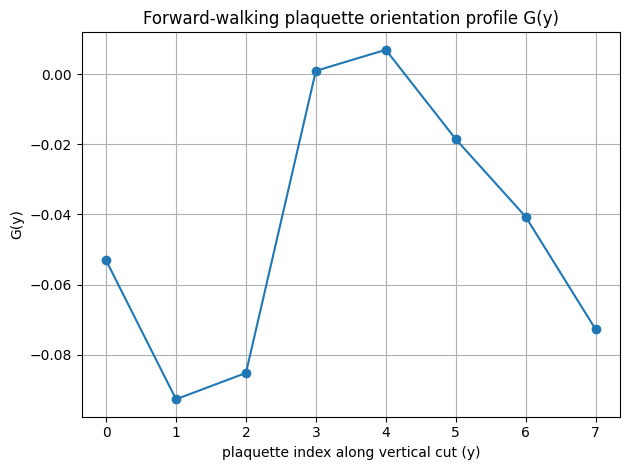

In [8]:
# ============================================================
# Main (example usage)
# ============================================================

if __name__ == "__main__":
    # -------------------------------
    # Choose simulation parameters
    # -------------------------------
    k = 4          # L = 2*k
    P = 0.5        # (J - V)/J parameter
    Nw = 20        # GFMC walkers (default 30)

    # -------------------------------
    # FULL VMC: optimize gamma for this (k, P)
    # -------------------------------
    
    
    # -------------------------------uncomment for gamma----------------------
    # gamma_grid = np.linspace(-1.0, 1.0, 9)  # e.g. [-1.0, -0.75, ..., 1.0]

    # vmc_res = vmc_optimize_gamma(
    #     k=k,
    #     P=P,
    #     gamma_values=gamma_grid,
    #     n_steps=20_000,     # keep moderate for testing; increase for production
    #     n_therm=5_000,
    #     measure_every=10,
    #     seed=12345,
    # )

    # gamma_best = vmc_res["gamma_best"]
    # print("\nVMC optimization results:")
    # for g, E, dE in zip(vmc_res["gamma_values"], vmc_res["E_means"], vmc_res["E_errs"]):
    #     print(f"  gamma={g:+.3f} -> E = {E:.6f} +/- {dE:.6f}")
    # print(f"Chosen gamma_best={gamma_best:+.3f}, "
    #       f"E_best={vmc_res['E_best']:.6f} +/- {vmc_res['E_best_err']:.6f}\n")
    # ------------------------------------------------------------------------------------------
    

    # -------------------------------
    # PARTIAL VMC example (commented out)
    #   Uncomment if you want to probe a single gamma manually.
    # -------------------------------
    # E_mean, E_err, vmc_info = vmc_run_single_gamma(
    #     k=k, P=P, gamma=0.0,
    #     n_steps=20_000,
    #     n_therm=5_000,
    #     measure_every=10,
    #     seed=12345,
    # )
    # print(f"[Partial VMC] gamma=0.0 -> E = {E_mean:.6f} +/- {E_err:.6f}")

    # -------------------------------
    # GFMC run using the optimized gamma as guiding
    # -------------------------------
    data = lgfmc(
        k=k,
        Nw=Nw,
        P=P,
        gamma=1.0,   # use VMC-optimized guiding parameter
        Mct=1_000,  # default 20_000
        Mck=50,     # default 100
        Mcx=1_000,   # default 10_000
        Mcf=200,    # default 1_000
    )
    print("GFMC run finished.")
    print("O shape:", data["O"].shape)

    # Forward-walking estimate of observables
    G = forward_walking_fwalk(data, L_hist=20, N_proj=20)
    L = data["L"]
    n_q = len(Q_PEAKS)

    # Unpack observables
    G_profile = G[0:L]
    avg_B = G[L]
    Sx_vals = G[L + 1 : L + 1 + n_q]
    Sy_vals = G[L + 1 + n_q : L + 1 + 2 * n_q]

    print("Ground-state <G(y)> profile shape:", G_profile.shape)
    print("Ground-state <B> (avg plaquette orientation):", avg_B)
    print("Ground-state Sx(q) at q = (pi,0),(0,pi),(pi,pi):", Sx_vals)
    print("Ground-state Sy(q) at q = (pi,0),(0,pi),(pi,pi):", Sy_vals)

    # Plot the profile G(y)
    y_sites = np.arange(L)
    plt.figure()
    plt.plot(y_sites, G_profile, marker="o")
    plt.xlabel("plaquette index along vertical cut (y)")
    plt.ylabel("G(y)")
    plt.title("Forward-walking plaquette orientation profile G(y)")
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig("forward_walking_profile.png", dpi=300)
    # plt.close()

    
    M_col, M_plaq = extract_order_parameters_from_G(G, L)
    print("Columnar-like order parameter M_col   =", M_col)
    print("Plaquette-like order parameter M_plaq =", M_plaq)

In [ ]:
# ============================================================
# Main (example usage)
# ============================================================

if __name__ == "__main__":
    v_over_t_list = np.linspace(-0.8, 0.8, 9)
    P_list = 1.0 - v_over_t_list
    for p in P_list:
        # -------------------------------
        # Choose simulation parameters
        # -------------------------------
        k = 4          # L = 2*k
        P = P_list        # (J - V)/J parameter
        Nw = 30        # GFMC walkers

        # -------------------------------
        # FULL VMC: optimize gamma for this (k, P)
        # -------------------------------
        
        
        # -------------------------------uncomment for gamma----------------------
        gamma_grid = np.linspace(-1.0, 1.0, 9)  # e.g. [-1.0, -0.75, ..., 1.0]

        vmc_res = vmc_optimize_gamma(
            k=k,
            P=P,
            gamma_values=gamma_grid,
            n_steps=20_000,     # keep moderate for testing; increase for production
            n_therm=5_000,
            measure_every=10,
            seed=12345,
        )

        gamma_best = vmc_res["gamma_best"]
        print("\nVMC optimization results:")
        for g, E, dE in zip(vmc_res["gamma_values"], vmc_res["E_means"], vmc_res["E_errs"]):
            print(f"  gamma={g:+.3f} -> E = {E:.6f} +/- {dE:.6f}")
        print(f"Chosen gamma_best={gamma_best:+.3f}, "
            f"E_best={vmc_res['E_best']:.6f} +/- {vmc_res['E_best_err']:.6f}\n")
        # ------------------------------------------------------------------------------------------
        

        # -------------------------------
        # PARTIAL VMC example (commented out)
        #   Uncomment if you want to probe a single gamma manually.
        # -------------------------------
        # E_mean, E_err, vmc_info = vmc_run_single_gamma(
        #     k=k, P=P, gamma=0.0,
        #     n_steps=20_000,
        #     n_therm=5_000,
        #     measure_every=10,
        #     seed=12345,
        # )
        # print(f"[Partial VMC] gamma=0.0 -> E = {E_mean:.6f} +/- {E_err:.6f}")

        # -------------------------------
        # GFMC run using the optimized gamma as guiding
        # -------------------------------
        data = lgfmc(
            k=k,
            Nw=Nw,
            P=P,
            gamma=gamma_best,   # use VMC-optimized guiding parameter
            Mct=20_000,
            Mck=100,
            Mcx=10_000,
            Mcf=1_000,
        )
        print("GFMC run finished.")
        print("O shape:", data["O"].shape)

        # Forward-walking estimate of observables
        G = forward_walking_fwalk(data, L_hist=20, N_proj=20)
        L = data["L"]
        n_q = len(Q_PEAKS)

        # Unpack observables
        G_profile = G[0:L]
        avg_B = G[L]
        Sx_vals = G[L + 1 : L + 1 + n_q]
        Sy_vals = G[L + 1 + n_q : L + 1 + 2 * n_q]

        print("Ground-state <G(y)> profile shape:", G_profile.shape)
        print("Ground-state <B> (avg plaquette orientation):", avg_B)
        print("Ground-state Sx(q) at q = (pi,0),(0,pi),(pi,pi):", Sx_vals)
        print("Ground-state Sy(q) at q = (pi,0),(0,pi),(pi,pi):", Sy_vals)

        # Plot the profile G(y)
        # y_sites = np.arange(L)
        # plt.figure()
        # plt.plot(y_sites, G_profile, marker="o")
        # plt.xlabel("plaquette index along vertical cut (y)")
        # plt.ylabel("G(y)")
        # plt.title("Forward-walking plaquette orientation profile G(y)")
        # plt.grid(True)
        # plt.tight_layout()
        # plt.savefig("forward_walking_profile.png", dpi=300)
        # plt.close()

        M_col, M_plaq = extract_order_parameters_from_G(G, L)
        print("Columnar-like order parameter M_col   =", M_col)
        print("Plaquette-like order parameter M_plaq =", M_plaq)